In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import pandas as pd
import sympy as sym
import warnings
import pickle as plk
from IPython.display import display, Math
from numpy.lib.scimath import sqrt as csqrt
from scipy.signal import find_peaks

import os
import imp
import sys
import importlib.util

###############################################################
# LINUX PATH

# sys.path.append("/opt/lumerical/v221/api/python") #Default linux lumapi path
# import lumapi
# sys.path.append(os.path.dirname('/home/trainner/Documentos/Caio/GitReps/Photonics-training/Projects/Optical_Hybrid/SimulationFiles')) #Current directory

###############################################################
# WINDOWS PATH

spec_win = importlib.util.spec_from_file_location('lumapi', 'C:\\Program Files\\Lumerical\\v202\\api\\python\\lumapi.py')
lumapi = importlib.util.module_from_spec(spec_win)
os.add_dll_directory("C:/Program Files/Lumerical/v202/api/python")
sys.path.append(os.path.dirname('C:/Users/Caio/Documents/GitHub/Photonics-training/Projects/Optical_Hybrid/SimulationFiles/'))
spec_win.loader.exec_module(lumapi)

In [2]:
hyb = lumapi.FDTD(filename='Hybrid.fsp',hide=False) 

## Functions

In [3]:
# Search for function's intersections on signal levels
def signalLv(yarray,level,type):
    peak, pd = find_peaks(yarray)
    maxpeak = yarray[peak[np.argmax(yarray[peak])]]
    minpeak = yarray[np.argmin(yarray)]
    index = []

    if(type == 'linear'):
        lvpeak = (maxpeak - minpeak)*level + minpeak
        for i in range(0,np.size(yarray)-1):
            if(((maxpeak-yarray[i]) - (maxpeak-lvpeak)) * ((maxpeak-yarray[i+1]) - (maxpeak-lvpeak)) <= 0):
                index.append(i)
        yMed = (yarray[index[0]] + yarray[index[-1]])/2

    if(type == 'log10'):
        lvpeak = maxpeak + 10*np.log10(level)
        for i in range(0,np.size(yarray)-1):
            if(((maxpeak-yarray[i]) - (maxpeak-lvpeak)) * ((maxpeak-yarray[i+1]) - (maxpeak-lvpeak)) <= 0):
                index.append(i)
        yMed = 10*np.log10((10**(yarray[index[0]]/2) + 10**(yarray[index[1]]/2))/2)

    return {'index':index,'yMed':yMed}


# Creates a box
def RectInsert(X,XSPAN,Y,YSPAN,Z,ZSPAN,MATERIAL,lumerical):
    
    lumerical.switchtolayout()
    lumerical.addrect()
    lumerical.set({"x":X,"y":Y,"z":Z,
         "x span":XSPAN, "y span":YSPAN, "z span":ZSPAN,
         "material":MATERIAL
        })


# Format a function/dataset as a polygon
def PolyForm(x,y,ybase):
    y2 = y + ybase
    A = np.zeros((2,len(x)+2))
    
    A[0][1:len(x)+1] = x
    A[1][1:len(x)+1] = y2
    A[0][0] = x[0]
    A[0][len(x)+1] = x[-1]
    A[1][0] = ybase
    A[1][len(x)+1] = ybase
    
    return A

## Assembly parameters

In [110]:
# Topology ------------------------------------
InnerBd = 2* 1.6e-6  # Inner body X span (Sum of both parts)
OuterBd = 2* 2.4e-6  # Outer body X span (Sum of both parts)

CentWid = 1.48e-6  # Central Width
InnerWid = 1.48e-6  # Inner Width
OuterWid = 1.6e-6  # Outer Width

TLen = 1e-6  # Tapper length

Material = "Si (Silicon) - Palik"

SXsp = 5e-6  # S band xspan
SYsp = 2.5e-6  # S band yspan


# Simulation ---------------------------------
FDTDAccuracy = 3
simTime = 3000e-15

MeshStep = [0.02e-6, 0.02e-6, 0.04e-6]

## Assembly

In [111]:
hyb.switchtolayout()
hyb.deleteall()

# Creating the Full Body
Verts = np.array([[0,CentWid/2], [InnerBd/2,InnerWid/2], [(InnerBd+OuterBd)/2,OuterWid/2],
         [(InnerBd+OuterBd)/2,-OuterWid/2], [InnerBd/2,-InnerWid/2], [0,-CentWid/2],
         [-InnerBd/2,-InnerWid/2], [-(InnerBd+OuterBd)/2,-OuterWid/2],
         [-(InnerBd+OuterBd)/2,OuterWid/2], [-InnerBd/2,InnerWid/2]])   # Vertices

Halflen = (InnerBd+OuterBd)/2 # MMI half length

MMIpos = {"x":[-4e-6 - Halflen-TLen-0.45e-6, 0 , 4e-6 + Halflen+TLen+0.45e-6],
          "y":[0,-4e-6 - Halflen-TLen-0.45e-6, 0],
          "angle":[0,90,180]}

GenPar = {"first axis":"z", "z":0,
         "len":TLen, "thickness":0.22e-6,
         "width_r":0.7e-6, "width_l":0.5e-6, 
         "angle_side":90}    # General parameter sets

GenPar2 = {"base angle":90, "base height":0.22e-6, "base width":0.5e-6,
           "x span":SXsp, "y span":SYsp, "first axis":"y", "material":Material}    # General parameter sets

# Creating MMIs and tappers
for i in range(3):
        hyb.addpoly()
        hyb.set("name", "FullBody " + str(i+1))
        hyb.set("vertices",Verts)
        hyb.set({"z span":220e-9, "material":Material})
        hyb.set({"x":0, "y":0, "z":0})
        hyb.addtogroup("MMI " + str(i+1))

        hyb.addobject("linear_taper")
        hyb.set(GenPar)
        hyb.set({"rotation 1":0, "name":"Input Taper 1",
                "x":-TLen/2-(InnerBd+OuterBd)/2, "y":OuterWid/2 - 0.35e-6})

        hyb.addobject("linear_taper")
        hyb.set(GenPar)
        hyb.set({"rotation 1":0, "name":"Input Taper 2",
                "x":-TLen/2-(InnerBd+OuterBd)/2, "y":-OuterWid/2 + 0.35e-6})

        hyb.addobject("linear_taper")
        hyb.set(GenPar)
        hyb.set({"rotation 1":180, "name":"Output Taper 1",
                "x":TLen/2+(InnerBd+OuterBd)/2, "y":OuterWid/2 - 0.35e-6})

        hyb.addobject("linear_taper")
        hyb.set(GenPar)
        hyb.set({"rotation 1":180, "name":"Output Taper 2",
                "x":TLen/2+(InnerBd+OuterBd)/2, "y":-OuterWid/2 + 0.35e-6})

        RectInsert(-TLen/2-(InnerBd+OuterBd)/2 - 1e-6 ,1e-6,
                   OuterWid/2 - 0.35e-6,0.5e-6,0,220e-9,Material,hyb)
        hyb.addtogroup("MMI " + str(i+1))

        RectInsert(-TLen/2-(InnerBd+OuterBd)/2 - 1e-6 ,1e-6,
                   -OuterWid/2 + 0.35e-6 ,0.5e-6,0,220e-9,Material,hyb)
        hyb.addtogroup("MMI " + str(i+1))

        hyb.addobject('s_bend_wg')
        hyb.set(GenPar2)
        hyb.set({"name":"Input bend 1", "rotation 1":180,
                "x":-TLen/2-(InnerBd+OuterBd)/2 - 1.5e-6, "y":0.45e-6, "z":0})

        hyb.addobject('s_bend_wg')
        hyb.set(GenPar2)
        hyb.set({"name":"Input bend 2", "rotation 1":0,
                "x":-SXsp -TLen/2-(InnerBd+OuterBd)/2 - 1.5e-6, "y":-0.45e-6-SYsp, "z":0})

        RectInsert(-TLen/2-(InnerBd+OuterBd)/2 - 2e-6-SXsp ,1e-6,
                   OuterWid/2 - 1.25e-6-SYsp,0.5e-6,0,220e-9,Material,hyb)
        hyb.addtogroup("MMI " + str(i+1))

        RectInsert(-TLen/2-(InnerBd+OuterBd)/2 - 2e-6-SXsp ,1e-6,
                   -OuterWid/2 + 1.25e-6+SYsp ,0.5e-6,0,220e-9,Material,hyb)
        hyb.addtogroup("MMI " + str(i+1))

        hyb.select("MMI " + str(i+1))
        hyb.set({"x":MMIpos["x"][i], "y":MMIpos["y"][i], "z":0, "first axis":"z"})
        hyb.set("rotation 1",MMIpos["angle"][i])


# Creating Y-Branch (LO entrance)
Verts = np.array([[-1e-6, 0.5e-6/2], [-0.833e-6, 0.5e-6/2], [-0.666e-6, 0.6e-6/2],
                  [-0.499e-6, 0.7e-6/2], [-0.332e-6, 0.9e-6/2], [-0.165e-6, 1.26e-6/2],
                  [0.002e-6, 1.4e-6/2], [0.169e-6, 1.4e-6/2], [0.336e-6, 1.4e-6/2],
                  [0.503e-6, 1.4e-6/2], [0.67e-6, 1.31e-6/2], [0.837e-6, 1.2e-6/2],
                  [1e-6, 1.2e-6/2],
                  
                  [1e-6, -1.2e-6/2], [0.837e-6, -1.2e-6/2], [0.67e-6, -1.31e-6/2],
                  [0.503e-6, -1.4e-6/2], [0.336e-6, -1.4e-6/2], [0.169e-6, -1.4e-6/2],
                  [0.002e-6, -1.4e-6/2], [-0.165e-6, -1.26e-6/2], [-0.332e-6, -0.9e-6/2],
                  [-0.499e-6, -0.7e-6/2], [-0.666e-6, -0.6e-6/2], [-0.833e-6, -0.5e-6/2],
                  [-1e-6, -0.5e-6/2]])   # Vertices
  
hyb.addpoly()
hyb.set("name", "FullBody")
hyb.set("vertices",Verts)
hyb.set({"x":0, "y":0, "z":0, "z span":220e-9,
        "material":Material})
hyb.addtogroup("LO Input")

RectInsert(-1.5e-6,1e-6,0,0.5e-6,0,220e-9,Material,hyb)
hyb.addtogroup("LO Input")

hyb.select("LO Input")
hyb.set("first axis","z")
hyb.set("rotation 1",270)
hyb.set({"x":0, "y":5.45e-6, "z":0})


# Bends and post-tappers
GenPar = {"base angle":90, "base height":0.22e-6, "base width":0.5e-6,
                 "radius":4e-6, "material":Material}    # General parameter sets

RectInsert(MMIpos["x"][0] + Halflen+TLen + 0.05e-6 ,0.1e-6 ,0.45e-6 ,0.5e-6 ,0,220e-9,Material,hyb)
hyb.set("name","Bend 2 extender")
RectInsert(MMIpos["x"][-1] - Halflen-TLen - 0.05e-6 ,0.1e-6 ,0.45e-6 ,0.5e-6 ,0,220e-9,Material,hyb)
hyb.set("name","Bend 3 extender")

hyb.addobject('90_bend_wg')
hyb.set(GenPar)
hyb.set({"start angle":270, "name":"Routing bend 2",
        "x":MMIpos["x"][0] + Halflen+TLen + 0.1e-6, "y":4e-6 + 0.45e-6, "z":0})

hyb.addobject('90_bend_wg')
hyb.set(GenPar)
hyb.set({"start angle":0, "name":"Routing bend 1",
        "x":MMIpos["x"][0] + Halflen+TLen, "y":- 4e-6 - 0.45e-6, "z":0})

hyb.addobject('90_bend_wg')
hyb.set(GenPar)
hyb.set({"start angle":180, "name":"Routing bend 3",
        "x":MMIpos["x"][-1] - Halflen-TLen - 0.1e-6, "y":4e-6 + 0.45e-6, "z":0})

hyb.addobject('90_bend_wg')
hyb.set(GenPar)
hyb.set({"start angle":90, "name":"Routing bend 4",
        "x":MMIpos["x"][-1] - Halflen-TLen, "y":- 4e-6 - 0.45e-6, "z":0})



# FDTD Setting
hyb.addfdtd()
hyb.set({"x":0, "y":-4.5e-6-SYsp, "z":0,
         "z span":3e-6,
         "simulation time":simTime, "mesh accuracy":FDTDAccuracy,
         "z min bc":"Symmetric"})
hyb.set({"x span":5*Halflen + 12.25e-6 + 2*SXsp, "y span": 4*Halflen+7.25e-6 + SXsp})
hyb.set("background material","SiO2 (Glass) - Palik")


# Creating Ports
hyb.addport()
hyb.set({"x":-3*Halflen -4e-6 -SXsp, "y":0.45e-6+SYsp, "z":0,
        "y span":3e-6, "z span":3e-6,
        "direction":"Forward"})

hyb.addport()
hyb.set({"x":-3*Halflen -4e-6 -SXsp, "y": -0.45e-6-SYsp, "z":0,
        "y span":3e-6, "z span":3e-6,
        "direction":"Forward"})

hyb.addport()
hyb.set({"x":3*Halflen +4e-6 +SXsp, "y":0.45e-6+SYsp, "z":0,
        "y span":3e-6, "z span":3e-6,
        "direction":"Backward"})

hyb.addport()
hyb.set({"x":3*Halflen +4e-6 +SXsp, "y": -0.45e-6-SYsp, "z":0,
        "y span":3e-6, "z span":3e-6,
        "direction":"Backward"})

hyb.addport()
hyb.set("injection axis","y-axis")
hyb.set({"x":-0.45e-6-SYsp, "y": -3*Halflen -4e-6 -SXsp, "z":0,
        "x span":3e-6, "z span":3e-6,
        "direction":"Forward"})

hyb.addport()
hyb.set("injection axis","y-axis")
hyb.set({"x":0, "y": 7e-6, "z":0,
        "x span":3e-6, "z span":3e-6,
        "direction":"Backward"})


# Editing source settings
hyb.select('FDTD::ports')
hyb.set('monitor frequency points',1200)
hyb.setglobalsource("wavelength start", 1500e-9)
hyb.setglobalsource("wavelength stop", 1600e-9)

# Creating monitor region
hyb.addpower()  # Planar monitor
hyb.set({"x":0, "x span":5*Halflen + 12e-6, "y":-4.5e-6, "y span":4*Halflen+7e-6})
hyb.setglobalmonitor("use source limits",0)
hyb.setglobalmonitor("minimum wavelength",1500e-9)
hyb.setglobalmonitor("maximum wavelength",1600e-9)
hyb.setglobalmonitor("frequency points",15)

# Meshs
hyb.addmesh()
hyb.set({"x min":-21.125e-6, "x max":21.125e-6,
         "y":0, "y span":6.5e-6,
         "z":0, "z span":3*220e-9,
         "dx":MeshStep[0], "dy":MeshStep[1], "dz":MeshStep[2],
         "name":"Center mesh"})

hyb.addmesh()
hyb.set({"x":0, "x span":2e-6,
         "y min":3.25e-6, "y max":7.2e-6,
         "z":0, "z span":3*220e-9,
         "dx":MeshStep[0], "dy":MeshStep[1], "dz":MeshStep[2],
         "name":"LO mesh"})

hyb.addmesh()
hyb.set({"x":0, "x span":6.5e-6,
         "y min":-21.125e-6, "y max":-3.25e-6,
         "z":0, "z span":3*220e-9,
         "dx":MeshStep[0], "dy":MeshStep[1], "dz":MeshStep[2],
         "name":"Bottom mesh"})

## Load

### Load transmission

dict_keys(['lambda', 'f', 'T', 'Lumerical_dataset'])


C:\Users\Caio\AppData\Local\Temp\ipykernel_11092\2901248058.py:26: RuntimeWarning: invalid value encountered in log10
  ax[1].plot(T5['lambda']*1e6, 10*np.log10(T5['T']), label='Tin')


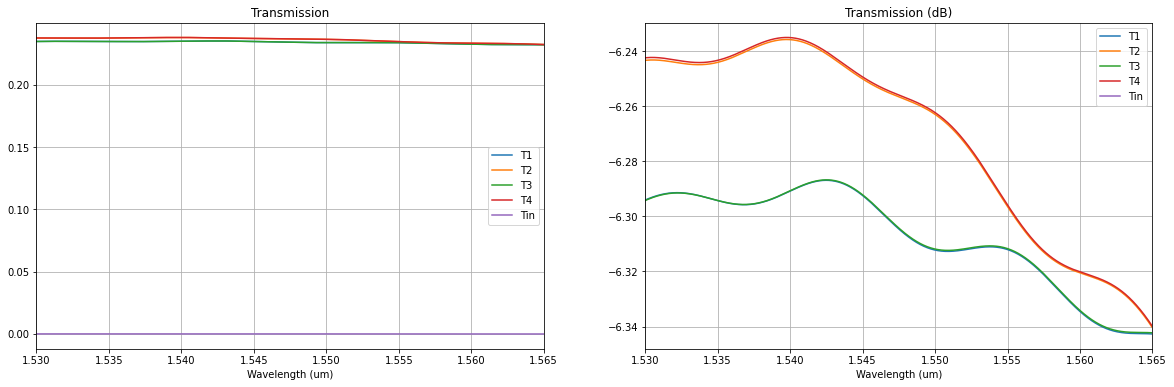

In [67]:
wavelim = [1.5, 1.6]

T1 = hyb.getresult("FDTD::ports::port 1","T")
T2 = hyb.getresult("FDTD::ports::port 2","T")
T3 = hyb.getresult("FDTD::ports::port 3","T")
T4 = hyb.getresult("FDTD::ports::port 4","T")
T5 = hyb.getresult("FDTD::ports::port 5","T")

print(T3.keys())
fig, ax = plt.subplots(1,2,figsize=(20,6))
ax[0].plot(T1['lambda']*1e6, -T1['T'], label='T1')
ax[0].plot(T2['lambda']*1e6, -T2['T'], label='T2')
ax[0].plot(T3['lambda']*1e6, T3['T'], label='T3')
ax[0].plot(T4['lambda']*1e6, T4['T'], label='T4')
ax[0].plot(T5['lambda']*1e6, T5['T'], label='Tin')
ax[0].set_title('Transmission')
ax[0].set_xlabel('Wavelength (um)')
ax[0].set_xlim(wavelim)
ax[0].grid(True)
ax[0].legend()

ax[1].plot(T1['lambda']*1e6, 10*np.log10(-T1['T']), label='T1')
ax[1].plot(T2['lambda']*1e6, 10*np.log10(-T2['T']), label='T2')
ax[1].plot(T3['lambda']*1e6, 10*np.log10(T3['T']), label='T3')
ax[1].plot(T4['lambda']*1e6, 10*np.log10(T4['T']), label='T4')
ax[1].plot(T5['lambda']*1e6, 10*np.log10(T5['T']), label='Tin')
ax[1].set_title('Transmission (dB)')
ax[1].set_xlabel('Wavelength (um)')
ax[1].set_xlim(wavelim)
ax[1].grid(True)
ax[1].legend()

### Load power

Text(0.5, 1.0, 'Eletric field distribution in dB 1542.32nm')

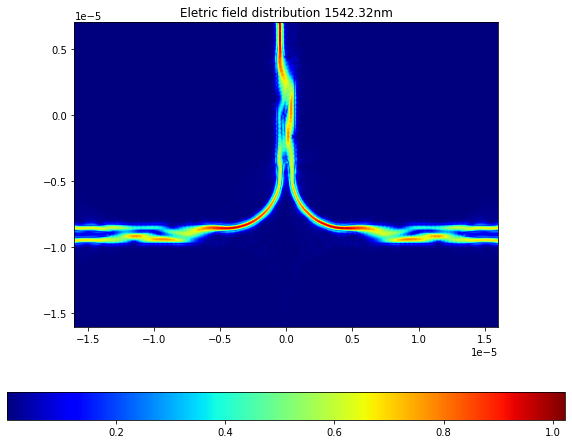

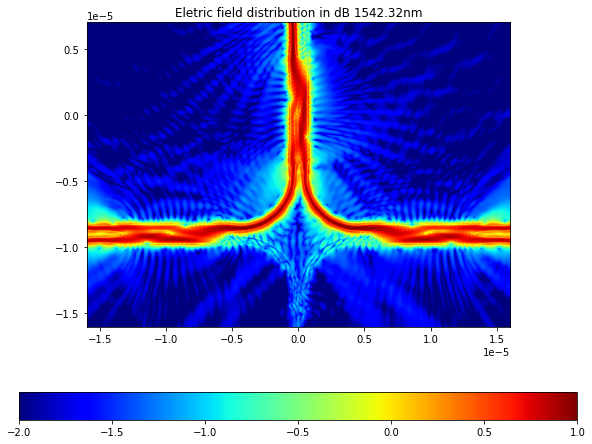

In [106]:
fIndex = 9  # Frequency index
CBLim = [0.001,1] # Colorbar limits

# Eletric field linear
E = hyb.getresult("monitor","E")
PwrArray = np.array(E['E'])

Ex = PwrArray[:,:,0,fIndex,0]
Ey = PwrArray[:,:,0,fIndex,1]
Ez = PwrArray[:,:,0,fIndex,2]

EAbs = np.sqrt(np.multiply(Ex,Ex) + np.multiply(Ey,Ey) + np.multiply(Ey,Ey))
Ax = ([ float(E['x'][0]) , float(E['x'][-1]) ])
Ay = ([ float(E['y'][0]) , float(E['y'][-1]) ])

EAbsClip = np.clip(EAbs,CBLim[0],CBLim[1])

# Plotting the color graph
plt.figure(figsize=(10,8))
ax = plt.imshow(np.abs(np.transpose(EAbsClip)),cmap ='jet', extent=[Ax[0],Ax[1],Ay[0],Ay[1]])
plt.colorbar(orientation='horizontal')
plt.title('Eletric field distribution {:.2f}nm'.format(1e9*float(P['lambda'][fIndex])))



# Eletric field log
E = hyb.getresult("monitor","E")
PwrArray = np.array(E['E'])

Ex = PwrArray[:,:,0,fIndex,0]
Ey = PwrArray[:,:,0,fIndex,1]
Ez = PwrArray[:,:,0,fIndex,2]

EAbs = np.abs(np.sqrt(np.multiply(Ex,Ex) + np.multiply(Ey,Ey) + np.multiply(Ey,Ey)))
Ax = ([ float(E['x'][0]) , float(E['x'][-1]) ])
Ay = ([ float(E['y'][0]) , float(E['y'][-1]) ])

EAbsClip = np.clip(EAbs,CBLim[0],CBLim[1])

# Plotting the color graph
plt.figure(figsize=(10,8))
ax = plt.imshow(np.log10(np.transpose(10*EAbsClip)),cmap ='jet', extent=[Ax[0],Ax[1],Ay[0],Ay[1]])
plt.colorbar(orientation='horizontal')
plt.title('Eletric field distribution in dB {:.2f}nm'.format(1e9*float(P['lambda'][fIndex])))

### Load S-parameters

#### Load Transmission and phase Signal

dict_keys(['lambda', 'f', 'S15', 'S16', 'S25', 'S26', 'S35', 'S36', 'S45', 'S46', 'S55', 'S56', 'S65', 'S66', 'Lumerical_dataset'])


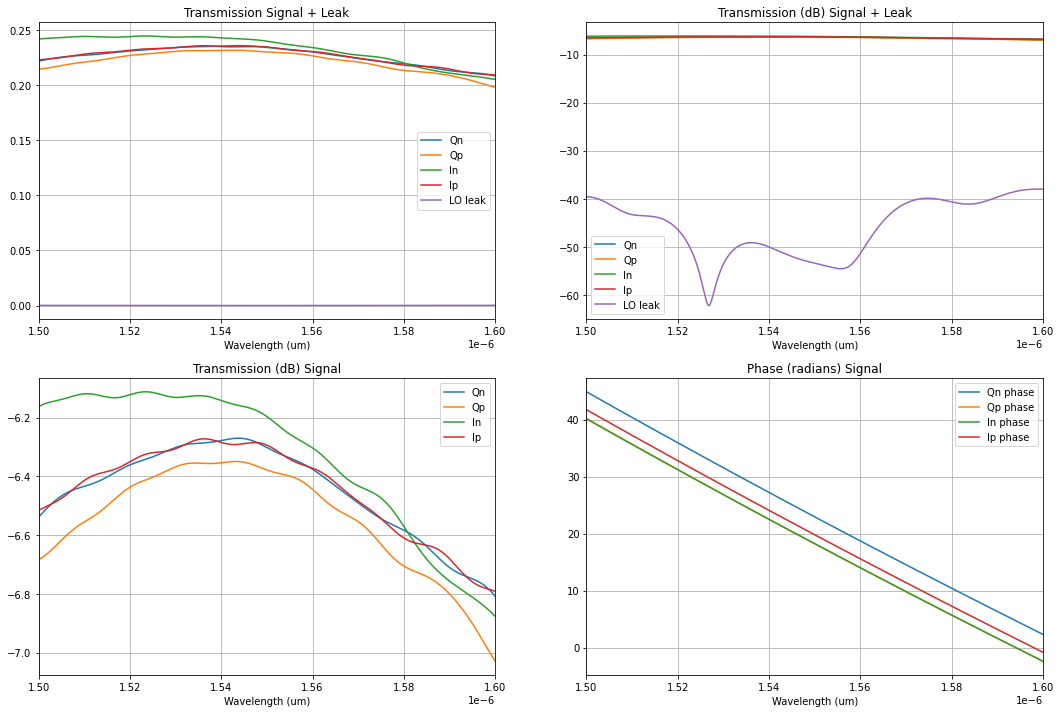

In [112]:
wavelim = [1.5e-6, 1.6e-6]

S = hyb.getsweepresult("s-parameter sweep", "S parameters")
print(S.keys())

SPort1 = S['S15']
SPort2 = S['S25']
SPort3 = S['S35']
SPort4 = S['S45']
SPort6 = S['S65']
fig, ax= plt.subplots(2,2,figsize=(18,12))
ax[0][0].plot(S['lambda'],np.abs(SPort1)**2, label='Qn')
ax[0][0].plot(S['lambda'],np.abs(SPort2)**2, label='Qp')
ax[0][0].plot(S['lambda'],np.abs(SPort3)**2, label='In')
ax[0][0].plot(S['lambda'],np.abs(SPort4)**2, label='Ip')
ax[0][0].plot(S['lambda'],np.abs(SPort6)**2, label='LO leak')
ax[0][0].set_title('Transmission Signal + Leak')
ax[0][0].set_xlabel('Wavelength (um)')
ax[0][0].set_xlim(wavelim)
ax[0][0].grid(True)
ax[0][0].legend() 

ax[0][1].plot(S['lambda'],10*np.log10(np.abs(SPort1)**2), label='Qn')
ax[0][1].plot(S['lambda'],10*np.log10(np.abs(SPort2)**2), label='Qp')
ax[0][1].plot(S['lambda'],10*np.log10(np.abs(SPort3)**2), label='In')
ax[0][1].plot(S['lambda'],10*np.log10(np.abs(SPort4)**2), label='Ip')
ax[0][1].plot(S['lambda'],10*np.log10(np.abs(SPort6)**2), label='LO leak')
ax[0][1].set_title('Transmission (dB) Signal + Leak')
ax[0][1].set_xlabel('Wavelength (um)')
ax[0][1].set_xlim(wavelim)
ax[0][1].grid(True)
ax[0][1].legend()

ax[1][0].plot(S['lambda'],10*np.log10(np.abs(SPort1)**2), label='Qn')
ax[1][0].plot(S['lambda'],10*np.log10(np.abs(SPort2)**2), label='Qp')
ax[1][0].plot(S['lambda'],10*np.log10(np.abs(SPort3)**2), label='In')
ax[1][0].plot(S['lambda'],10*np.log10(np.abs(SPort4)**2), label='Ip')
ax[1][0].set_title('Transmission (dB) Signal')
ax[1][0].set_xlabel('Wavelength (um)')
ax[1][0].set_xlim(wavelim)
ax[1][0].grid(True)
ax[1][0].legend()

ax[1][1].plot(S['lambda'], hyb.unwrap(np.angle(SPort1)), label='Qn phase')
ax[1][1].plot(S['lambda'], hyb.unwrap(np.angle(SPort2)), label='Qp phase')
ax[1][1].plot(S['lambda'], hyb.unwrap(np.angle(SPort3)), label='In phase')
ax[1][1].plot(S['lambda'], hyb.unwrap(np.angle(SPort4)), label='Ip phase')
ax[1][1].set_title('Phase (radians) Signal')
ax[1][1].set_xlabel('Wavelength (um)')
ax[1][1].set_xlim(wavelim)
ax[1][1].grid(True)
ax[1][1].legend()


#### Load Transmission and phase LO

dict_keys(['lambda', 'f', 'S15', 'S16', 'S25', 'S26', 'S35', 'S36', 'S45', 'S46', 'S55', 'S56', 'S65', 'S66', 'Lumerical_dataset'])


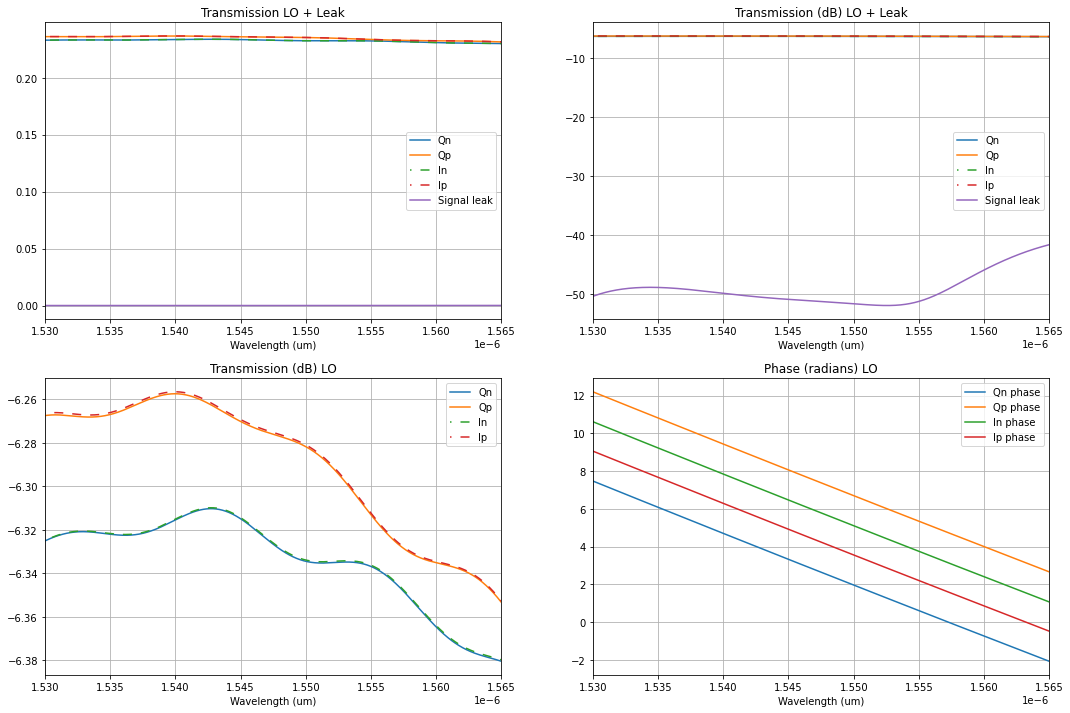

In [103]:
wavelim = [1.5e-6, 1.6e-6]

S = hyb.getsweepresult("s-parameter sweep", "S parameters")
print(S.keys())

SPort1 = S['S16']
SPort2 = S['S26']
SPort3 = S['S36']
SPort4 = S['S46']
SPort5 = S['S56']
fig, ax= plt.subplots(2,2,figsize=(18,12))
ax[0][0].plot(S['lambda'],np.abs(SPort1)**2, label='Qn')
ax[0][0].plot(S['lambda'],np.abs(SPort2)**2, label='Qp')
ax[0][0].plot(S['lambda'],np.abs(SPort3)**2, linestyle=(5, (6, 6)), label='In')
ax[0][0].plot(S['lambda'],np.abs(SPort4)**2, linestyle=(5, (6, 6)), label='Ip')
ax[0][0].plot(S['lambda'],np.abs(SPort5)**2, label='Signal leak')
ax[0][0].set_title('Transmission LO + Leak')
ax[0][0].set_xlabel('Wavelength (um)')
ax[0][0].set_xlim(wavelim)
ax[0][0].grid(True)
ax[0][0].legend() 

ax[0][1].plot(S['lambda'],10*np.log10(np.abs(SPort1)**2), label='Qn')
ax[0][1].plot(S['lambda'],10*np.log10(np.abs(SPort2)**2), label='Qp')
ax[0][1].plot(S['lambda'],10*np.log10(np.abs(SPort3)**2),linestyle=(5, (6, 6)),label='In')
ax[0][1].plot(S['lambda'],10*np.log10(np.abs(SPort4)**2),linestyle=(5, (6, 6)), label='Ip')
ax[0][1].plot(S['lambda'],10*np.log10(np.abs(SPort5)**2), label='Signal leak')
ax[0][1].set_title('Transmission (dB) LO + Leak')
ax[0][1].set_xlabel('Wavelength (um)')
ax[0][1].set_xlim(wavelim)
ax[0][1].grid(True)
ax[0][1].legend()

ax[1][0].plot(S['lambda'],10*np.log10(np.abs(SPort1)**2), label='Qn')
ax[1][0].plot(S['lambda'],10*np.log10(np.abs(SPort2)**2), label='Qp')
ax[1][0].plot(S['lambda'],10*np.log10(np.abs(SPort3)**2),linestyle=(5, (6, 6)),label='In')
ax[1][0].plot(S['lambda'],10*np.log10(np.abs(SPort4)**2),linestyle=(5, (6, 6)), label='Ip')
ax[1][0].set_title('Transmission (dB) LO')
ax[1][0].set_xlabel('Wavelength (um)')
ax[1][0].set_xlim(wavelim)
ax[1][0].grid(True)
ax[1][0].legend()

ax[1][1].plot(S['lambda'], hyb.unwrap(np.angle(SPort1)), label='Qn phase')
ax[1][1].plot(S['lambda'], hyb.unwrap(np.angle(SPort2)), label='Qp phase')
ax[1][1].plot(S['lambda'], hyb.unwrap(np.angle(SPort3)), label='In phase')
ax[1][1].plot(S['lambda'], hyb.unwrap(np.angle(SPort4)), label='Ip phase')
ax[1][1].set_title('Phase (radians) LO')
ax[1][1].set_xlabel('Wavelength (um)')
ax[1][1].set_xlim(wavelim)
ax[1][1].grid(True)
ax[1][1].legend()

#### Load CMRR and loss

dict_keys(['lambda', 'f', 'S15', 'S16', 'S25', 'S26', 'S35', 'S36', 'S45', 'S46', 'S55', 'S56', 'S65', 'S66', 'Lumerical_dataset'])


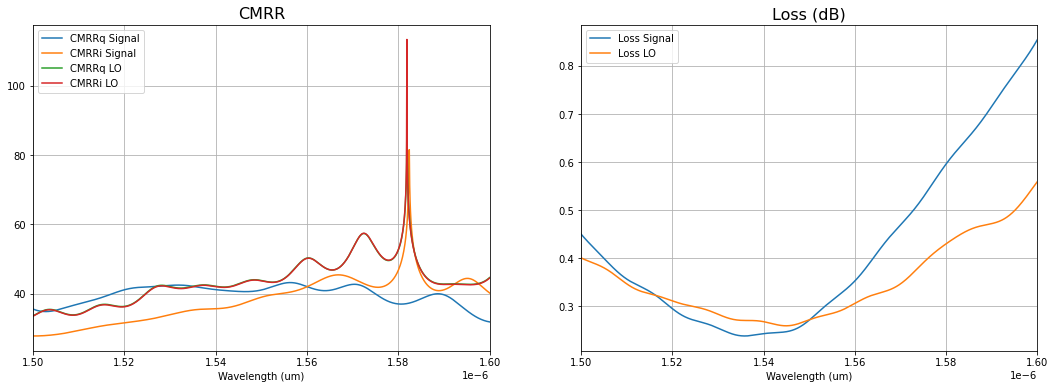

In [113]:
wavelim = [1.5e-6, 1.6e-6]

S = hyb.getsweepresult("s-parameter sweep", "S parameters")
print(S.keys())

SPort1 = S['S15']
SPort2 = S['S25']
SPort3 = S['S35']
SPort4 = S['S45']
SPort6 = S['S65']

SPort1LO = S['S16']
SPort2LO = S['S26']
SPort3LO = S['S36']
SPort4LO = S['S46']
SPort5LO = S['S56']

fig, ax= plt.subplots(1,2,figsize=(18,6))
CMRRq = 20*np.log10(np.abs( (np.abs(SPort2)**2 - np.abs(SPort1)**2) / (np.abs(SPort2)**2 + np.abs(SPort1)**2) ))
CMRRi = 20*np.log10(np.abs( (np.abs(SPort4)**2 - np.abs(SPort3)**2) / (np.abs(SPort4)**2 + np.abs(SPort3)**2) ))
CMRRqLO = 20*np.log10(np.abs( (np.abs(SPort2LO)**2 - np.abs(SPort1LO)**2) / (np.abs(SPort2LO)**2 + np.abs(SPort1LO)**2) ))
CMRRiLO = 20*np.log10(np.abs( (np.abs(SPort4LO)**2 - np.abs(SPort3LO)**2) / (np.abs(SPort4LO)**2 + np.abs(SPort3LO)**2) ))
ax[0].plot(S['lambda'],-CMRRq, label='CMRRq Signal')
ax[0].plot(S['lambda'],-CMRRi, label='CMRRi Signal')
ax[0].plot(S['lambda'],-CMRRqLO, label='CMRRq LO')
ax[0].plot(S['lambda'],-CMRRiLO, label='CMRRi LO')
ax[0].set_title('CMRR',fontsize=16)
ax[0].set_xlabel('Wavelength (um)')
ax[0].set_xlim(wavelim)
ax[0].grid(True)
ax[0].legend() 

ax[1].plot(S['lambda'],-10*np.log10( ( (np.abs(SPort1)**2) + (np.abs(SPort2)**2) + (np.abs(SPort3)**2) + (np.abs(SPort4)**2))), label='Loss Signal')
ax[1].plot(S['lambda'],-10*np.log10( ( (np.abs(SPort1LO)**2) + (np.abs(SPort2LO)**2) + (np.abs(SPort3LO)**2) + (np.abs(SPort4LO)**2))), label='Loss LO')
ax[1].set_title('Loss (dB)',fontsize=16)
ax[1].set_xlabel('Wavelength (um)')
ax[1].set_xlim(wavelim)
#ax[1].set_ylim(0,1)
ax[1].grid(True)
ax[1].legend()

#### Load Imbalance

dict_keys(['lambda', 'f', 'S15', 'S16', 'S25', 'S26', 'S35', 'S36', 'S45', 'S46', 'S55', 'S56', 'S65', 'S66', 'Lumerical_dataset'])


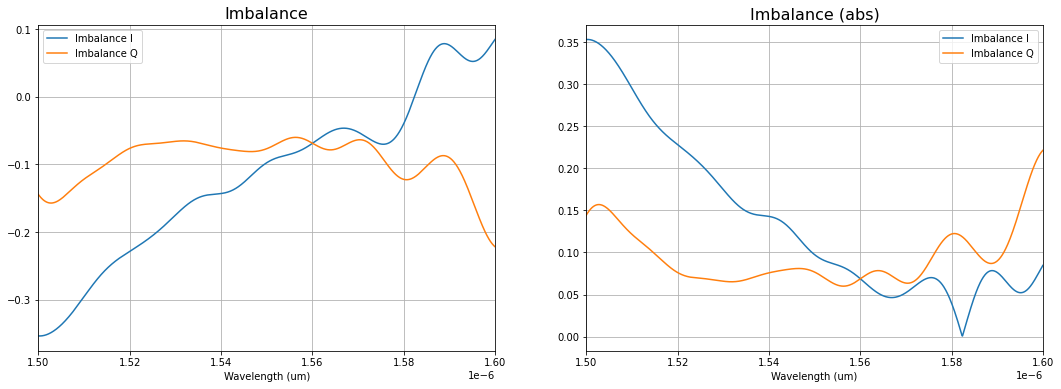

In [114]:
wavelim = [1.5e-6, 1.6e-6]

S = hyb.getsweepresult("s-parameter sweep", "S parameters")
print(S.keys())

SPort1 = S['S15']
SPort2 = S['S25']
SPort3 = S['S35']
SPort4 = S['S45']
SPort6 = S['S65']

SPort1LO = S['S16']
SPort2LO = S['S26']
SPort3LO = S['S36']
SPort4LO = S['S46']
SPort5LO = S['S56']

fig, ax= plt.subplots(1,2,figsize=(18,6))
imbI = 10*np.log10(np.abs(SPort4)**2 / np.abs(SPort3)**2)
imbQ = 10*np.log10(np.abs(SPort2)**2 / np.abs(SPort1)**2)
ax[0].plot(S['lambda'],imbI, label='Imbalance I')
ax[0].plot(S['lambda'],imbQ, label='Imbalance Q')
ax[0].set_title('Imbalance',fontsize=16)
ax[0].set_xlabel('Wavelength (um)')
ax[0].set_xlim(wavelim)
ax[0].grid(True)
ax[0].legend() 

ax[1].plot(S['lambda'],np.abs(imbI), label='Imbalance I')
ax[1].plot(S['lambda'],np.abs(imbQ), label='Imbalance Q')
ax[1].set_title('Imbalance (abs)',fontsize=16)
ax[1].set_xlabel('Wavelength (um)')
ax[1].set_xlim(wavelim)
ax[1].grid(True)
ax[1].legend()

#### Phase error

dict_keys(['lambda', 'f', 'S15', 'S16', 'S25', 'S26', 'S35', 'S36', 'S45', 'S46', 'S55', 'S56', 'S65', 'S66', 'Lumerical_dataset'])


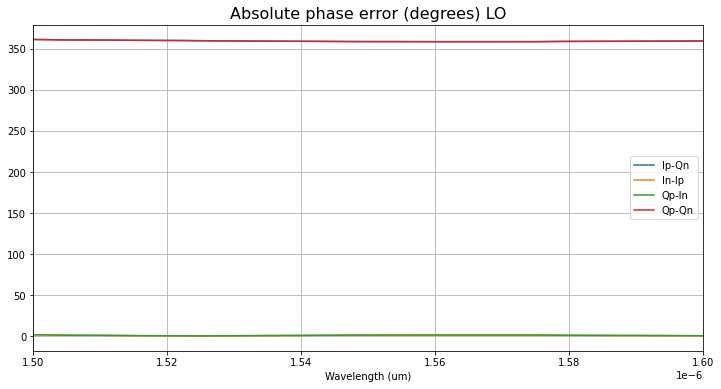

In [115]:
wavelim = [1.5e-6, 1.6e-6]

S = hyb.getsweepresult("s-parameter sweep", "S parameters")
print(S.keys())

SPort1 = S['S16']
SPort2 = S['S26']
SPort3 = S['S36']
SPort4 = S['S46']
SPort5 = S['S56']

plt.figure(figsize=(12,6))
plt.plot(S['lambda'], 180/np.pi *(np.abs( np.pi/2 - hyb.unwrap(np.angle(SPort4)) + hyb.unwrap(np.angle(SPort1)) )), label='Ip-Qn')
plt.plot(S['lambda'], 180/np.pi *(np.abs( np.pi/2 - hyb.unwrap(np.angle(SPort3)) + hyb.unwrap(np.angle(SPort4)) )), label='In-Ip')
plt.plot(S['lambda'], 180/np.pi *(np.abs( np.pi/2 - hyb.unwrap(np.angle(SPort2)) + hyb.unwrap(np.angle(SPort3)) )), label='Qp-In')
plt.plot(S['lambda'], 180/np.pi *(np.abs( np.pi/2 - hyb.unwrap(np.angle(SPort4)) + hyb.unwrap(np.angle(SPort1)) )), label='Qp-Qn')
plt.title('Absolute phase error (degrees) LO',fontsize=16)
plt.xlabel('Wavelength (um)')
plt.xlim(wavelim)
plt.grid(True)
plt.legend()